Copyright (c) Meta Platforms, Inc. and affiliates.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/co-tracker/blob/main/notebooks/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# CoTracker: It is Better to Track Together
This is a demo for <a href="https://co-tracker.github.io/">CoTracker</a>, a model that can track any point in a video.

<img src="https://www.robots.ox.ac.uk/~nikita/storage/cotracker/bmx-bumps.gif" alt="Logo" width="50%">

Don't forget to turn on GPU support if you're running this demo in Colab.

**Runtime** -> **Change runtime type** -> **Hardware accelerator** -> **GPU**

Let's install dependencies for Colab:

In [ ]:
# !git clone https://github.com/facebookresearch/co-tracker
# %cd co-tracker
# !pip install -e .
# !pip install opencv-python matplotlib moviepy flow_vis
# !mkdir checkpoints
# %cd checkpoints
# !wget https://huggingface.co/facebook/cotracker3/resolve/main/scaled_offline.pth

In [1]:
import os
import torch

from base64 import b64encode
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML

Read a video from CO3D:

In [2]:
cd co-tracker/

/home/fick17/Desktop/JY/ycb/co-tracker


In [3]:
video = read_video_from_path('./assets/video_front_no_occ.mp4')
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()

In [4]:
def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="640" height="480" autoplay loop controls><source src="{video_url}"></video>""")

show_video("./assets/video_front_no_occ.mp4")

Import CoTrackerPredictor and create an instance of it. We'll use this object to estimate tracks:

In [5]:
from cotracker.predictor import CoTrackerPredictor

model = CoTrackerPredictor(
    checkpoint=os.path.join(
        './checkpoints/scaled_offline.pth'
    )
)

In [6]:
if torch.cuda.is_available():
    model = model.cuda()
    video = video.cuda()

Track points sampled on a regular grid of size 30\*30 on the first frame:

In [10]:
pred_tracks, pred_visibility = model(video, grid_size=10)

Visualize and save the result:

In [11]:
vis = Visualizer(save_dir='./videos', pad_value=100)
vis.visualize(video=video, tracks=pred_tracks, visibility=pred_visibility, filename='teaser');

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (456, 456) to (464, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ./videos/teaser.mp4


In [12]:
show_video("./videos/teaser.mp4")

## Tracking manually selected points

We will start by tracking points queried manually.
We define a queried point as: [time, x coord, y coord]

So, the code below defines points with different x and y coordinates sampled on frames 0, 10, 20, and 30:

In [ ]:
queries = torch.tensor([
    [0., 400., 350.],  # point tracked from the first frame
    [10., 600., 500.], # frame number 10
    [20., 750., 600.], # ...
    [30., 900., 200.]
])
if torch.cuda.is_available():
    queries = queries.cuda()

That's what our queried points look like:

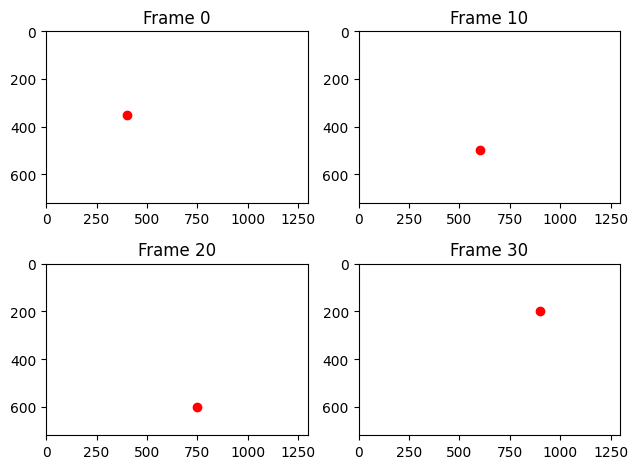

In [ ]:
import matplotlib.pyplot as plt
# Create a list of frame numbers corresponding to each point
frame_numbers = queries[:,0].int().tolist()

fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

for i, (query, frame_number) in enumerate(zip(queries, frame_numbers)):
    ax = axs[i]
    ax.plot(query[1].item(), query[2].item(), 'ro')

    ax.set_title("Frame {}".format(frame_number))
    ax.set_xlim(0, video.shape[4])
    ax.set_ylim(0, video.shape[3])
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

We pass these points as input to the model and track them:

In [ ]:
pred_tracks, pred_visibility = model(video, queries=queries[None])

Finally, we visualize the results with tracks leaving traces from the frame where the tracking starts.
Color encodes time:

In [ ]:
vis = Visualizer(
    save_dir='./videos',
    linewidth=6,
    mode='cool',
    tracks_leave_trace=-1
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='queries');

Video saved to ./videos/queries.mp4


In [ ]:
show_video("./videos/queries.mp4")

Notice that points queried at frames 10, 20, and 30 are tracked **incorrectly** before the query frame. This is because CoTracker is an online algorithm and only tracks points in one direction. However, we can also run it backward from the queried point to track in both directions. Let's correct this:

In [ ]:
pred_tracks, pred_visibility = model(video, queries=queries[None], backward_tracking=True)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='queries_backward');

Video saved to ./videos/queries_backward.mp4


In [ ]:
show_video("./videos/queries_backward.mp4")

## Points on a regular grid

### Tracking forward from the frame number x

Let's now sample points on a regular grid and start tracking from the frame number 20 with a grid of 30\*30.

In [ ]:
grid_size = 30
grid_query_frame = 20

In [ ]:
pred_tracks, pred_visibility = model(video, grid_size=grid_size, grid_query_frame=grid_query_frame)

In [ ]:
vis = Visualizer(save_dir='./videos', pad_value=100)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='grid_query_20',
    query_frame=grid_query_frame);

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1496, 920) to (1504, 928) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6363e40] Warning: data is not aligned! This can lead to a speed loss


Video saved to ./videos/grid_query_20.mp4


Note that tracking starts only from points sampled on a frame in the middle of the video. This is different from the grid in the first example:

In [ ]:
show_video("./videos/grid_query_20.mp4")

### Tracking forward **and backward** from the frame number x

In [ ]:
grid_size = 30
grid_query_frame = 20

Let's activate backward tracking:

In [ ]:
pred_tracks, pred_visibility = model(video, grid_size=grid_size, grid_query_frame=grid_query_frame, backward_tracking=True)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='grid_query_20_backward');

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1496, 920) to (1504, 928) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5734e40] Warning: data is not aligned! This can lead to a speed loss


Video saved to ./videos/grid_query_20_backward.mp4


As you can see, we are now tracking points queried in the middle from the first frame:

In [ ]:
show_video("./videos/grid_query_20_backward.mp4")

## Regular grid + Segmentation mask

Let's now sample points on a grid and filter them with a segmentation mask.
This allows us to track points sampled densely on an object because we consume less GPU memory.

In [28]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
grid_size = 20

In [29]:
input_mask = './assets/mask.png'
segm_mask = np.array(Image.open(input_mask))

That's a segmentation mask for the first frame:

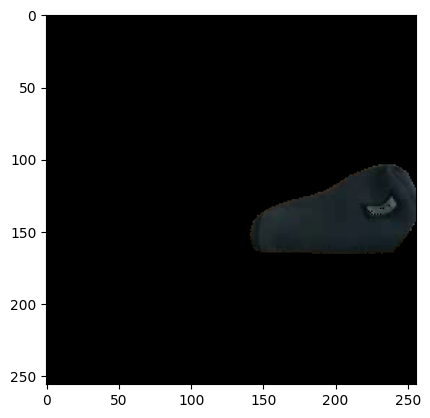

In [30]:
plt.imshow((segm_mask[...,None]/255.*video[0,0].permute(1,2,0).cpu().numpy()/255.))

In [31]:
pred_tracks, pred_visibility = model(video, grid_size=grid_size, segm_mask=torch.from_numpy(segm_mask)[None, None])
vis = Visualizer(
    save_dir='./videos',
    pad_value=100,
    linewidth=2,
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='segm_grid');

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (456, 456) to (464, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ./videos/segm_grid.mp4


In [27]:
show_video("./videos/segm_grid.mp4")

## Dense Tracks

### Tracking forward **and backward** from the frame number x

CoTracker also has a mode to track **every pixel** in a video in a **dense** manner but it is much slower than in previous examples. Let's downsample the video in order to make it faster:

In [ ]:
video.shape

torch.Size([1, 50, 3, 720, 1296])

In [ ]:
import torch.nn.functional as F
video_interp = F.interpolate(video[0], [200, 360], mode="bilinear")[None]

The video now has a much lower resolution:

In [ ]:
video_interp.shape

torch.Size([1, 50, 3, 200, 360])

In [ ]:
grid_query_frame=20

Again, let's track points in both directions. This will only take a couple of minutes:

In [ ]:
pred_tracks, pred_visibility = model(video_interp, grid_query_frame=grid_query_frame, backward_tracking=True)

step 0 / 4
step 1 / 4
step 2 / 4
step 3 / 4


Visualization with an optical flow color encoding:

In [ ]:
vis = Visualizer(
    save_dir='./videos',
    pad_value=20,
    linewidth=1,
    mode='optical_flow'
)
vis.visualize(
    video=video_interp,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename='dense');

Video saved to ./videos/dense.mp4


In [ ]:
show_video("./videos/dense.mp4")

That's all, now you can use CoTracker in your projects!